In [1]:
import pandas as pd
!pip install Census


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


### Data Exploration of Rates

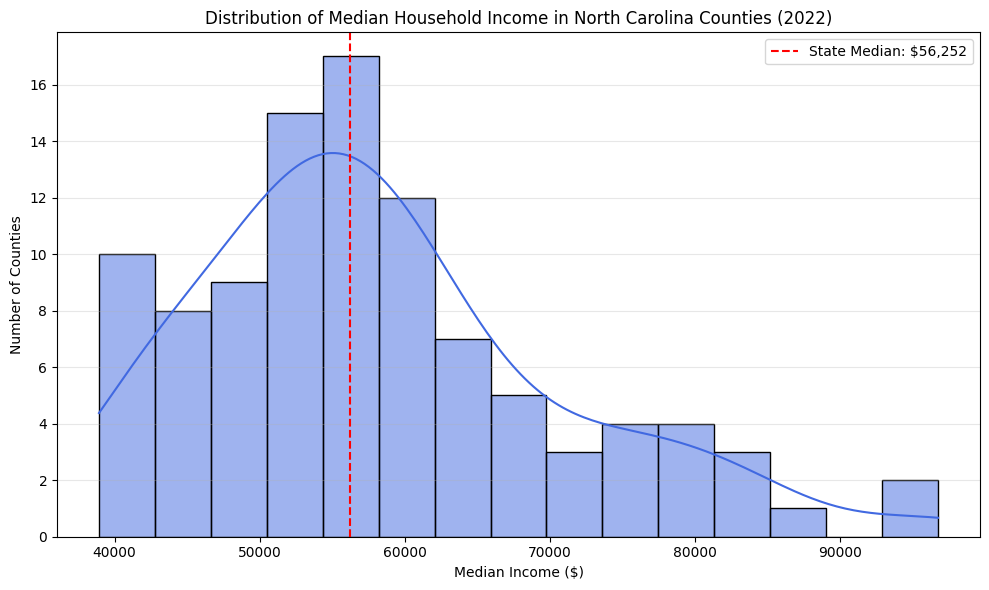

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv("/work/nc_county_economics_2022_simplified.csv")

# Create the distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df['median_income'], kde=True, bins=15, color='royalblue')

# Add plot formatting
plt.title('Distribution of Median Household Income in North Carolina Counties (2022)')
plt.xlabel('Median Income ($)')
plt.ylabel('Number of Counties')
plt.grid(axis='y', alpha=0.3)

# Add vertical line for state median
state_median = df['median_income'].median()
plt.axvline(state_median, color='red', linestyle='--', 
            label=f'State Median: ${state_median:,.0f}')

plt.legend()
plt.tight_layout()
plt.show()

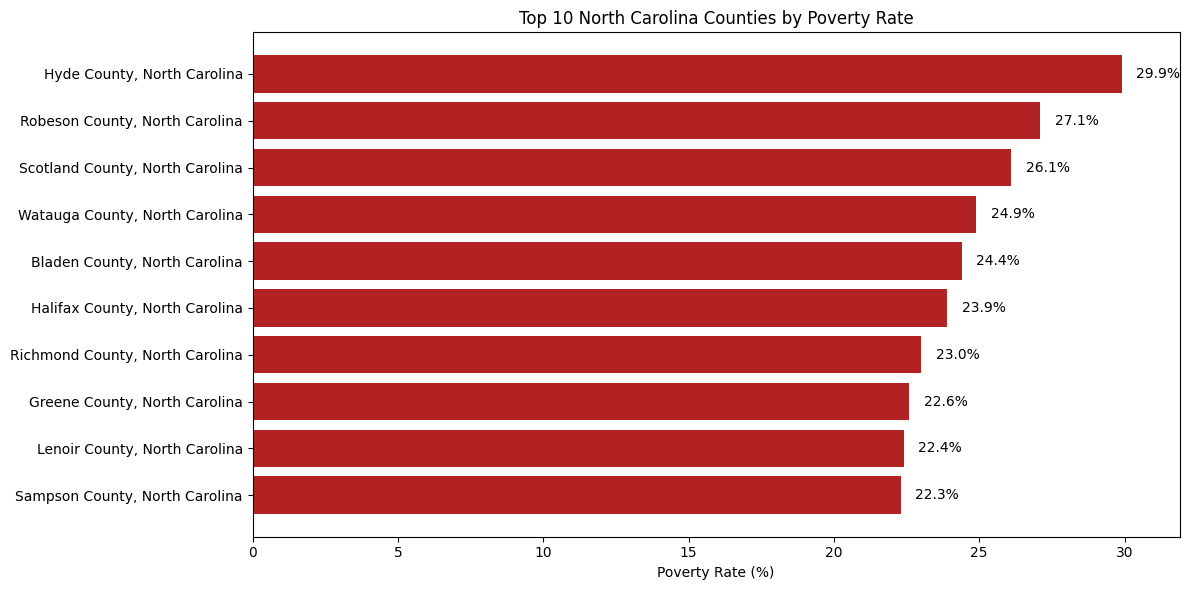

In [3]:
# Get top 10 high poverty counties
top10 = df.nlargest(10, 'poverty_rate')

plt.figure(figsize=(12, 6))
bars = plt.barh(top10['county_name'], top10['poverty_rate'],
                color='firebrick')

plt.title('Top 10 North Carolina Counties by Poverty Rate')
plt.xlabel('Poverty Rate (%)')
plt.xlim(0, top10['poverty_rate'].max() + 2)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%',
             ha='left', va='center')

plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.show()

In [4]:
import requests
import pandas as pd

API_KEY = "b0020349489f775fe8f35c5ad2d4d4f4e3336472"

def get_nc_county_data():
    # First API call - Population
    pop_vars = ["NAME", "B01001_001E"]
    pop_url = f"https://api.census.gov/data/2022/acs/acs5?get={','.join(pop_vars)}&for=county:*&in=state:37&key={API_KEY}"
    
    # Second API call - Poverty data (just getting poverty rate now)
    poverty_vars = ["S1701_C03_001E"]  # Only keeping poverty rate
    poverty_url = f"https://api.census.gov/data/2022/acs/acs5/subject?get={','.join(poverty_vars)}&for=county:*&in=state:37&key={API_KEY}"
    
    # Third API call - Economic data
    economic_vars = ["DP03_0062E", "DP03_0119PE"]
    economic_url = f"https://api.census.gov/data/2022/acs/acs5/profile?get={','.join(economic_vars)}&for=county:*&in=state:37&key={API_KEY}"
    
    # Fourth API call - Health Insurance
    health_vars = ["S2701_C03_001E"]
    health_url = f"https://api.census.gov/data/2022/acs/acs5/subject?get={','.join(health_vars)}&for=county:*&in=state:37&key={API_KEY}"

    # Make requests and create DataFrames
    pop_df = pd.DataFrame(requests.get(pop_url).json()[1:], 
                       columns=["county_name", "total_population", "state", "county"])
    poverty_df = pd.DataFrame(requests.get(poverty_url).json()[1:], 
                           columns=["poverty_rate", "state", "county"])
    economic_df = pd.DataFrame(requests.get(economic_url).json()[1:], 
                            columns=["median_income", "snap_percent", "state", "county"])
    health_df = pd.DataFrame(requests.get(health_url).json()[1:], 
                          columns=["health_insurance_percent", "state", "county"])
    
    # Convert all numeric columns
    for df in [pop_df, poverty_df, economic_df, health_df]:
        for col in df.columns:
            if col not in ["state", "county", "county_name"]:
                df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Merge all DataFrames
    merged_df = pop_df.merge(poverty_df, on=["state", "county"])\
                     .merge(economic_df, on=["state", "county"])\
                     .merge(health_df, on=["state", "county"])
    
    # Calculate uninsured percentage
    merged_df["uninsured_percent"] = 100 - merged_df["health_insurance_percent"]
    
    # Reorder and select only needed columns
    final_cols = [
        "county_name", "county",  # Keeping county code for reference
        "total_population", 
        "poverty_rate",
        "median_income", 
        "snap_percent", 
        "health_insurance_percent", 
        "uninsured_percent"
    ]
    
    return merged_df[final_cols]

# Get and save the data
try:
    nc_data = get_nc_county_data()
    nc_data.to_csv("nc_county_economics_2022_simplified.csv", index=False)
    print("Data successfully saved!")
    print(nc_data.head())
except Exception as e:
    print(f"Error: {str(e)}")

Data successfully saved!
                        county_name county  total_population  poverty_rate  \
0   Alamance County, North Carolina    001            171779          14.2   
1  Alexander County, North Carolina    003             36505          12.2   
2  Alleghany County, North Carolina    005             10989          19.5   
3      Anson County, North Carolina    007             22200          19.3   
4       Ashe County, North Carolina    009             26759          14.1   

   median_income  snap_percent  health_insurance_percent  uninsured_percent  
0          60866          10.5                      90.3                9.7  
1          62764           8.1                      90.9                9.1  
2          42115          12.0                      86.6               13.4  
3          42000          14.8                      87.0               13.0  
4          49176          10.1                      89.0               11.0  


In [23]:
import requests
import pandas as pd

API_KEY = "b0020349489f775fe8f35c5ad2d4d4f4e3336472"

def get_nc_county_data():
    # First API call - Population
    pop_vars = ["NAME", "B01001_001E"]
    pop_url = f"https://api.census.gov/data/2022/acs/acs5?get={','.join(pop_vars)}&for=county:*&in=state:37&key={API_KEY}"
    
    # Second API call - Poverty data
    poverty_vars = ["S1701_C03_001E"]
    poverty_url = f"https://api.census.gov/data/2022/acs/acs5/subject?get={','.join(poverty_vars)}&for=county:*&in=state:37&key={API_KEY}"
    
    # Third API call - Economic data
    economic_vars = ["DP03_0062E", "DP03_0119PE"]
    economic_url = f"https://api.census.gov/data/2022/acs/acs5/profile?get={','.join(economic_vars)}&for=county:*&in=state:37&key={API_KEY}"
    
    # Fourth API call - Health Insurance
    health_vars = ["S2701_C03_001E"]
    health_url = f"https://api.census.gov/data/2022/acs/acs5/subject?get={','.join(health_vars)}&for=county:*&in=state:37&key={API_KEY}"
    
    # Fifth API call - Education (Bachelor's degree or higher)
    education_vars = ["S1501_C02_015E"]
    education_url = f"https://api.census.gov/data/2022/acs/acs5/subject?get={','.join(education_vars)}&for=county:*&in=state:37&key={API_KEY}"
    
    # Sixth API call - Unemployment
    unemployment_vars = ["S2301_C04_001E"]
    unemployment_url = f"https://api.census.gov/data/2022/acs/acs5/subject?get={','.join(unemployment_vars)}&for=county:*&in=state:37&key={API_KEY}"

    # Make requests and create DataFrames
    pop_df = pd.DataFrame(requests.get(pop_url).json()[1:], 
                       columns=["county_name", "total_population", "state", "county"])
    poverty_df = pd.DataFrame(requests.get(poverty_url).json()[1:], 
                           columns=["poverty_rate", "state", "county"])
    economic_df = pd.DataFrame(requests.get(economic_url).json()[1:], 
                            columns=["median_income", "snap_percent", "state", "county"])
    health_df = pd.DataFrame(requests.get(health_url).json()[1:], 
                          columns=["health_insurance_percent", "state", "county"])
    education_df = pd.DataFrame(requests.get(education_url).json()[1:],
                             columns=["percent_bachelors_or_higher", "state", "county"])
    unemployment_df = pd.DataFrame(requests.get(unemployment_url).json()[1:],
                                columns=["unemployment_rate", "state", "county"])
    
    # Convert all numeric columns
    for df in [pop_df, poverty_df, economic_df, health_df, education_df, unemployment_df]:
        for col in df.columns:
            if col not in ["state", "county", "county_name"]:
                df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Merge all DataFrames
    merged_df = pop_df.merge(poverty_df, on=["state", "county"])\
                     .merge(economic_df, on=["state", "county"])\
                     .merge(health_df, on=["state", "county"])\
                     .merge(education_df, on=["state", "county"])\
                     .merge(unemployment_df, on=["state", "county"])
    
    # Calculate uninsured percentage
    merged_df["uninsured_percent"] = 100 - merged_df["health_insurance_percent"]
    
    # Reorder and select only needed columns
    final_cols = [
        "county_name", "county",
        "total_population", 
        "poverty_rate",
        "median_income", 
        "snap_percent", 
        "health_insurance_percent", 
        "uninsured_percent",
        "percent_bachelors_or_higher",
        "unemployment_rate"
    ]
    
    return merged_df[final_cols]

# Get and save the data
try:
    nc_data = get_nc_county_data()
    nc_data.to_csv("nc_county_census_total.csv", index=False)
    print("Data successfully saved!")
    print(nc_data.head())
except Exception as e:
    print(f"Error: {str(e)}")

Data successfully saved!
                        county_name county  total_population  poverty_rate  \
0   Alamance County, North Carolina    001            171779          14.2   
1  Alexander County, North Carolina    003             36505          12.2   
2  Alleghany County, North Carolina    005             10989          19.5   
3      Anson County, North Carolina    007             22200          19.3   
4       Ashe County, North Carolina    009             26759          14.1   

   median_income  snap_percent  health_insurance_percent  uninsured_percent  \
0          60866          10.5                      90.3                9.7   
1          62764           8.1                      90.9                9.1   
2          42115          12.0                      86.6               13.4   
3          42000          14.8                      87.0               13.0   
4          49176          10.1                      89.0               11.0   

   percent_bachelors_or_higher 